# Домашнее задание №8 "Feature Selection"

In [11]:
pip install delayed

Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns

In [15]:
from sklearn.feature_selection import SequentialFeatureSelector

In [16]:
from matplotlib.lines import Line2D
# from sklearn.compose import ColumnTransformer

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [172]:
data = pd.read_csv('Kobe.csv')

In [87]:
data.head(100)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Jump Shot,Jump Shot,184,20000068,33.7933,-58,251,-118.3278,3,2,...,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-11-08,LAL @ SAS,SAS,96
96,Jump Shot,Jump Shot,192,20000068,33.8843,-94,160,-118.3638,3,2,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-11-08,LAL @ SAS,SAS,97
97,Jump Shot,Jump Shot,215,20000068,33.8943,-193,150,-118.4628,0,2,...,3PT Field Goal,Left Side Center(LC),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-11-08,LAL @ SAS,SAS,98
98,Jump Shot,Jump Shot,217,20000068,34.0443,140,0,-118.1298,0,2,...,2PT Field Goal,Right Side(R),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-11-08,LAL @ SAS,SAS,99


In [82]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

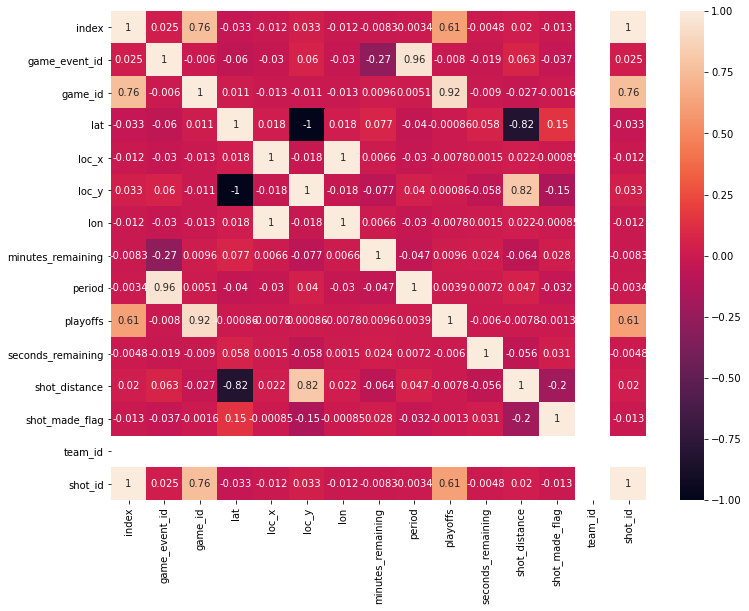

In [18]:
# Посмотрим на матрицу корреляций

corr = data.corr()
plt.figure(figsize=(12,9))
sns.heatmap(corr,annot=True)
plt.show()

Видим некоторые признаки с высокой степень корреляции, такие как lat/shot_distabce, game_id/playoffs. Некоторые даже имеют полную линейную зависимость (lat/loc_y, lon/loc_x).

Также видим абсолютно ненужный столбцы team_id. Он везде одинаков, так как Коби всю карьеру играл за одну команду. Веротяно в дальнейшем при уменьшении признакогового пространства такие признаки, как team_name, team_id, matchup удалятся.

### 'Некоторые блоки кода взяты из примеров на Kaggle

C:\Users\Reb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


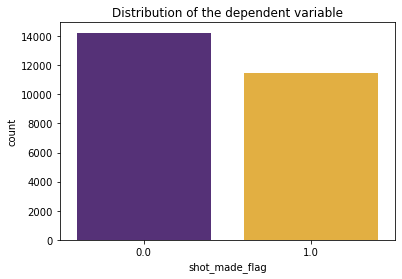

In [19]:
# Оценим распределение целевого класса:

ax = plt.axes()
sns.countplot("shot_made_flag", data=data, ax=ax, palette=("#552583", "#FDB927"))
ax.set_title("Distribution of the dependent variable")
plt.show()

Видим, что целевая переменная распределна относительно равномерно, т.е. дисбаланса классов не наблюдается.

Построим график, отображающий попадания в зависимости от позиции, в которой был сделан бросок.

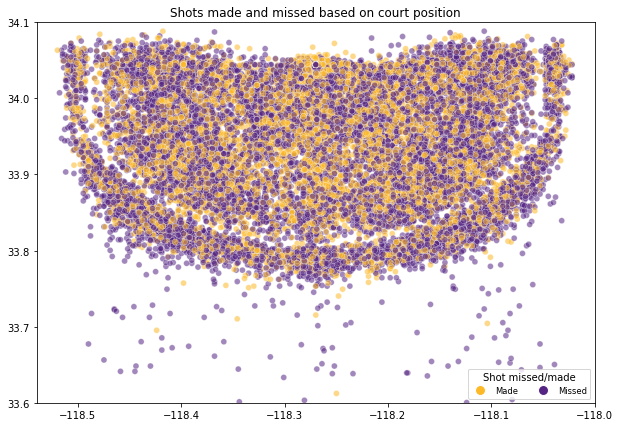

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
scatter = sns.scatterplot(x=data["lon"], y=data["lat"], hue=data['shot_made_flag'],
                                    alpha=0.55, ax=ax, palette=("#552583", "#FDB927"))
scatter.set_xlim(left=-118.54, right=-118)
scatter.set_ylim(bottom=33.6, top=34.1)
ax.set_title("Shots made and missed based on court position")
ax.set_xlabel("")
ax.set_ylabel("")
legend_elemnts = [Line2D([0], [0], marker="o", color='w', label="Made",
                         markerfacecolor="#FDB927", markersize=10),
                  Line2D([0], [0], marker="o", color='w', label="Missed",
                         markerfacecolor="#552583", markersize=10)]
plt.legend(handles=legend_elemnts, title="Shot missed/made", 
           ncol=2, fontsize='small', fancybox=True);

Видим, что чем ближе к кольцу, тем попаданий больше. Что конечно логично. Также кажется, что броски из центральной части площадки чаще достигали цели.

## Формируем признаковое пространство

Преобразуем в нормальное время:

In [173]:
data.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


In [174]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

In [175]:
#Преобразуем признак период в категориальную переменную
data['period'] = data['period'].astype('object')

In [176]:
#Удалим некоторые признаки, которые явно не помогут решению задачи

data = data.drop(['season','game_date', 'matchup','team_id', 'team_name', 'action_type', 
                  'game_event_id', 'opponent', 'game_id'], axis =1 )
data.head()

,combined_shot_type,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,shot_id
0,Jump Shot,33.9723,167,72,-118.1028,10,1,0,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1
1,Jump Shot,34.0443,-157,0,-118.4268,10,1,0,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,2
2,Jump Shot,33.9093,-101,135,-118.3708,7,1,0,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,3
3,Jump Shot,33.8693,138,175,-118.1318,6,1,0,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,4
4,Dunk,34.0443,0,0,-118.2698,6,2,0,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,5


In [177]:
final_data = pd.get_dummies(data, drop_first=True)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 37 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   lat                                    30697 non-null  float64
 1   loc_x                                  30697 non-null  int64  
 2   loc_y                                  30697 non-null  int64  
 3   lon                                    30697 non-null  float64
 4   minutes_remaining                      30697 non-null  int64  
 5   playoffs                               30697 non-null  int64  
 6   seconds_remaining                      30697 non-null  int64  
 7   shot_distance                          30697 non-null  int64  
 8   shot_made_flag                         25697 non-null  float64
 9   shot_id                                30697 non-null  int64  
 10  combined_shot_type_Dunk                30697 non-null  uint8  
 11  co

In [186]:
# Удалим строки, в которых признак "shot_made_flag" не известен
final_data_1 = final_data.dropna(subset=['shot_made_flag']).reset_index()
final_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25697 entries, 0 to 25696
Data columns (total 38 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   index                                  25697 non-null  int64  
 1   lat                                    25697 non-null  float64
 2   loc_x                                  25697 non-null  int64  
 3   loc_y                                  25697 non-null  int64  
 4   lon                                    25697 non-null  float64
 5   minutes_remaining                      25697 non-null  int64  
 6   playoffs                               25697 non-null  int64  
 7   seconds_remaining                      25697 non-null  int64  
 8   shot_distance                          25697 non-null  int64  
 9   shot_made_flag                         25697 non-null  float64
 10  shot_id                                25697 non-null  int64  
 11  co

## Обучаем модели

In [320]:
X = final_data_1.drop('shot_made_flag', 1)

y = final_data_1['shot_made_flag']

In [321]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25697 entries, 0 to 25696
Data columns (total 37 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   index                                  25697 non-null  int64  
 1   lat                                    25697 non-null  float64
 2   loc_x                                  25697 non-null  int64  
 3   loc_y                                  25697 non-null  int64  
 4   lon                                    25697 non-null  float64
 5   minutes_remaining                      25697 non-null  int64  
 6   playoffs                               25697 non-null  int64  
 7   seconds_remaining                      25697 non-null  int64  
 8   shot_distance                          25697 non-null  int64  
 9   shot_id                                25697 non-null  int64  
 10  combined_shot_type_Dunk                25697 non-null  uint8  
 11  co

In [322]:
# СТандартизируем наши данные

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_st = scaler.fit_transform(X)


In [261]:
models = {'LinearRegr' : LinearRegression(), 'Lasso' : Lasso(alpha=0.0001), 'Ridge' : Ridge(alpha=0.1)}

In [263]:
X_tr, X_t, Y_tr, Y_t = train_test_split(X_st, y, test_size = 0.2, shuffle = True, \
                                        stratify = y, random_state = 42)

In [266]:
from sklearn.metrics import accuracy_score

In [267]:
def train_test_models(models, X_tr, X_t, Y_tr, Y_t):
    models_res = {}
    for model in models:
        preds = []
        models[model].fit(X_tr, Y_tr)
        for pred in models[model].predict(X_t):
            if pred > 0.5:
                preds.append(1)
            else:
                preds.append(0)
        print(f'{model}: acc{accuracy_score(Y_t, preds)}, roc_auc {roc_auc_score(Y_t, models[model].predict(X_t))}')
        models_res[model] = {
                                'model' : models[model],
                                'accuracy' : accuracy_score(Y_t, preds),
                                'preds' : list(preds),
                                'coef' : models[model].coef_
                            }
    return models_res


In [323]:
m_r = train_test_models(models, X_tr, X_t, Y_tr, Y_t)

# Видим, что все можеи показали похожий результат

LinearRegr: acc0.6120622568093386, roc_auc 0.6274680151607548
Lasso: acc0.6116731517509728, roc_auc 0.62691479742182
Ridge: acc0.6120622568093386, roc_auc 0.6268850800630068


In [325]:
# Построим сравнительную таблицу коэффициентов

df_coef = pd.DataFrame()
df_coef['Features'] = X.columns
df_coef['LinearRegression'] = m_r['LinearRegr']['coef']
df_coef['Lasso'] = m_r['Lasso']['coef']
df_coef['Ridge'] = m_r['Ridge']['coef']

In [326]:
df_coef

,Features,LinearRegression,Lasso,Ridge
0,index,1.077625e+07,-2.394927e-03,-0.001988
1,lat,-5.219683e+10,1.558883e-03,0.001336
2,loc_x,-3.667647e+10,-7.249870e-03,-0.004434
3,loc_y,-5.219683e+10,-9.180598e-07,-0.001336
4,lon,3.667647e+10,-2.042776e-07,-0.004434
5,minutes_remaining,8.026779e-03,8.036305e-03,0.008071
6,playoffs,2.266802e-03,1.856496e-03,0.002225
7,seconds_remaining,1.136382e-02,1.129644e-02,0.011379
8,shot_distance,-5.502106e-02,-5.301998e-02,-0.054663
9,shot_id,-1.077625e+07,-1.168093e-03,-0.001988


In [327]:
# Для наглядность отобразим в графическо виде уровень значимости признаков

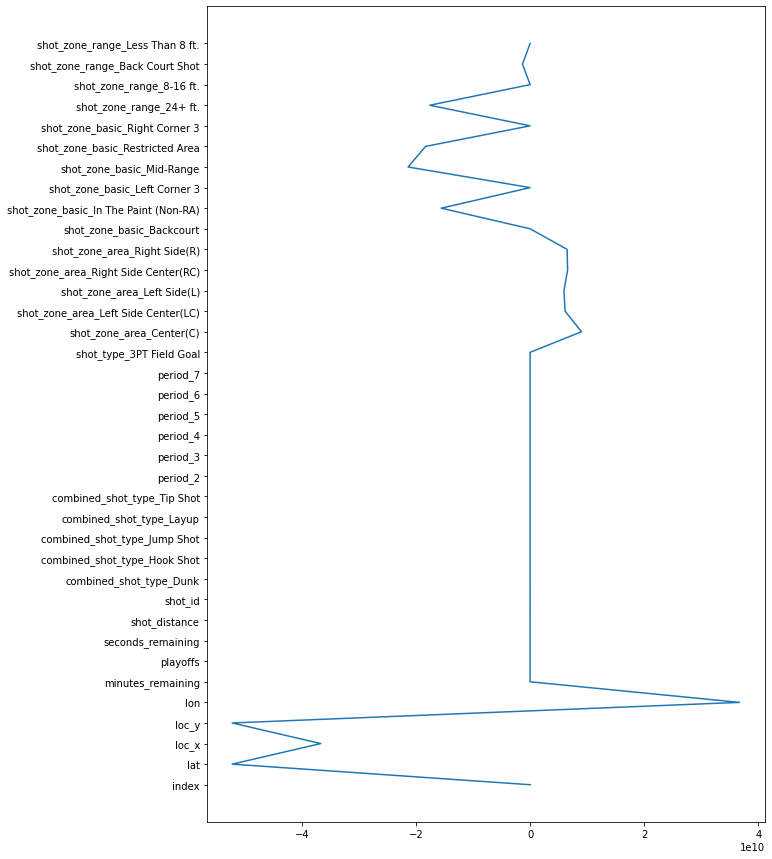

In [318]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 15))
plt.plot(df_coef['LinearRegression'], df_coef['Features'])

# Видим, что для линейно регрессии самые важные признаки это координаты (loc_x, loc_y, lat), зоны, из которых проихвожился бросок

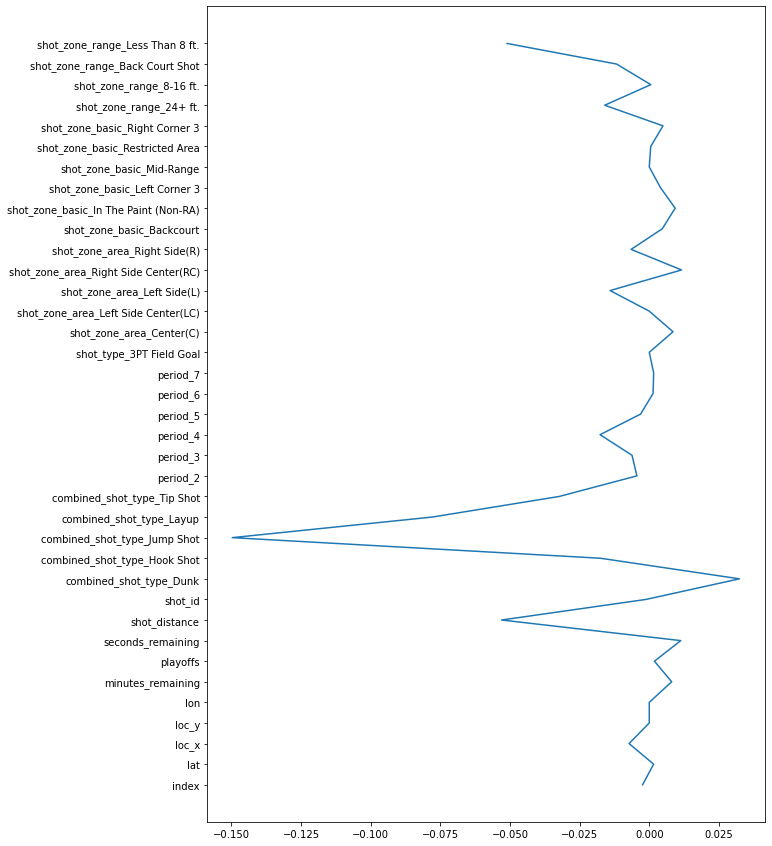

In [315]:
plt.figure(figsize = (10, 15))
plt.plot(df_coef['Lasso'], df_coef['Features'])

# Для Лассо все признаки в той или иной степени окаывают влияние. Самое сильное - тип броска и дистанция

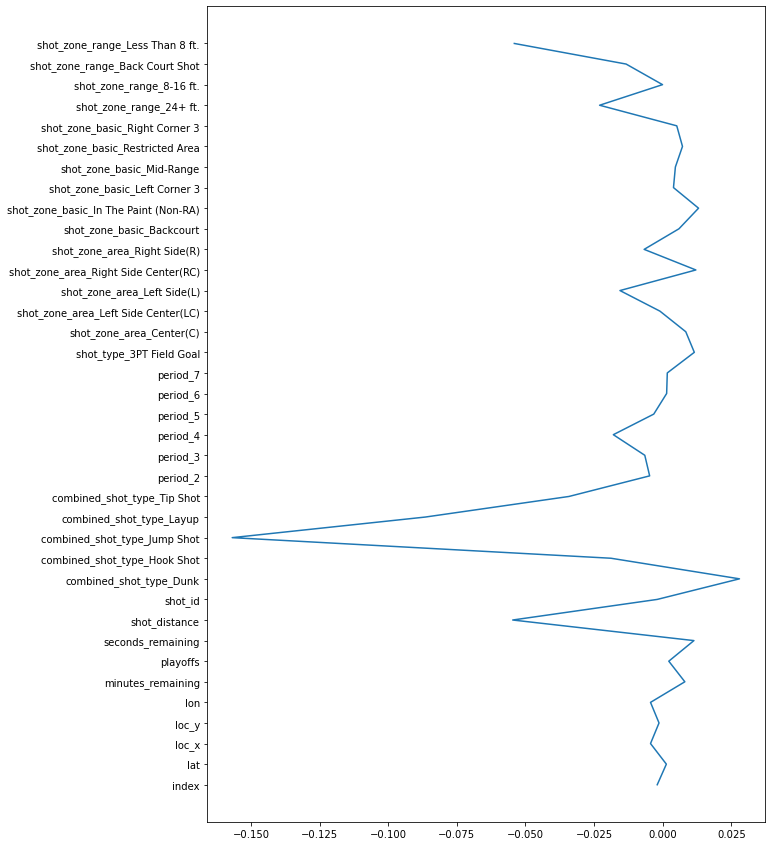

In [316]:
plt.figure(figsize = (10, 15))
plt.plot(df_coef['Ridge'], df_coef['Features'])

# Для Лассо (как и для Lasso) все признаки в той или иной степени окаывают влияние. Самое сильное - тип броска и дистанция